<a href="https://colab.research.google.com/github/thaCripple/CCC_Image_Classifier/blob/main/CCC_img_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision
from torchvision.transforms import v2

In [2]:
!pip install -q torchmetrics

In [3]:
import torchmetrics

In [4]:
from sklearn.metrics import classification_report

# Get the data

## Load the images from a Google Drive folder

Path to Images on my Google Drive

In [5]:
IMAGES_DIR = Path("/content/drive/MyDrive/ccc_images")
IMAGES_DIR

PosixPath('/content/drive/MyDrive/ccc_images')

In [6]:
test_imgs_dir = IMAGES_DIR / "test"
train_imgs_dir = IMAGES_DIR / "train"

Create a simple transform to visualize some images

In [7]:
transform0 = v2.Compose([
    v2.ToImage()
])

Load original images into a DataLoader

In [8]:
train_ds_showcase = torchvision.datasets.ImageFolder(root=train_imgs_dir, transform=transform0)

In [9]:
train_ds_showcase.classes

['cat', 'chicken', 'cow']

In [10]:
train_dl_showcase = torch.utils.data.DataLoader(dataset=train_ds_showcase, batch_size=1, shuffle=True)
train_dl_showcase

Plot some sample images

In [11]:
def prep_sample_img(sample: list[torch.Tensor, torch.Tensor])->torch.Tensor:
  """
  Prepare a single image from the dataset to be plotted with matplotlib

  Parameters
  ----------
  sample: list of a single img tensor and label number tensor pair returned by a Dataloader

  Returns
  ----------
  A Tensor suitable for matplotlib's imshow
  """

  # Get the image and remove the batch dimension
  sample_img = sample[0]
  new_shape = (sample_img.shape[1:])
  sample_img = sample_img.reshape(new_shape)

  # Change the format into Channel Last
  sample_img = torch.movedim(input=sample_img, source=0, destination=-1)

  return sample_img

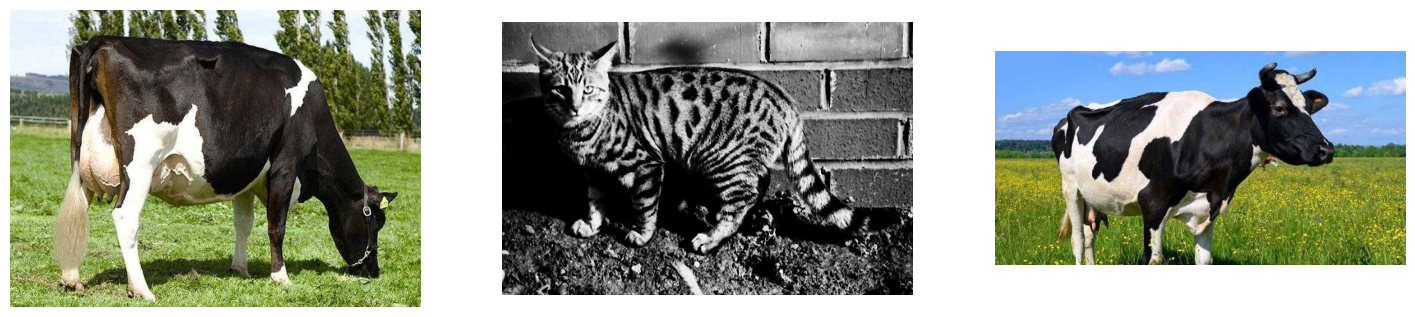

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,12))
for ax in axes:
  ax.imshow(prep_sample_img(sample=next(iter(train_dl_showcase))))
  ax.axis(False)

# Prepare the data for Machine Learning
We want to start with non augmented images.

* The original images need to be converted from .jpg to Tensors
* They need to be scaled to 64x64
* The dtype needs to be changed to torch.float32

## Create train and test dataloaders

In [13]:
test_imgs_dir = IMAGES_DIR / "test"
train_imgs_dir = IMAGES_DIR / "train"

In [14]:
transform_no_augment = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(64,64)),
    v2.ToDtype(dtype=torch.float32, scale=True)
])

In [15]:
BATCH_SIZE = 16

In [16]:
train_ds_no_augment = torchvision.datasets.ImageFolder(root=train_imgs_dir, transform=transform_no_augment)
train_dl_no_augment = torch.utils.data.DataLoader(dataset=train_ds_no_augment, batch_size=BATCH_SIZE, shuffle=True, num_workers=1,  prefetch_factor=3)

In [17]:
test_ds_no_augment = torchvision.datasets.ImageFolder(root=test_imgs_dir, transform=transform_no_augment)
test_dl_no_augment = torch.utils.data.DataLoader(dataset=test_ds_no_augment, batch_size=BATCH_SIZE, shuffle=False, num_workers=1,  prefetch_factor=3)

Check and Visualize some images

In [18]:
x_batch, y_batch = next(iter(train_dl_no_augment))
sample_img, sample_lbl = x_batch[0], y_batch[0]
print(f"Shape of a single image: {sample_img.shape}")
print(f"Corresponding class: {train_ds_no_augment.classes[sample_lbl]}")

Shape of a single image: torch.Size([3, 64, 64])
Corresponding class: cow


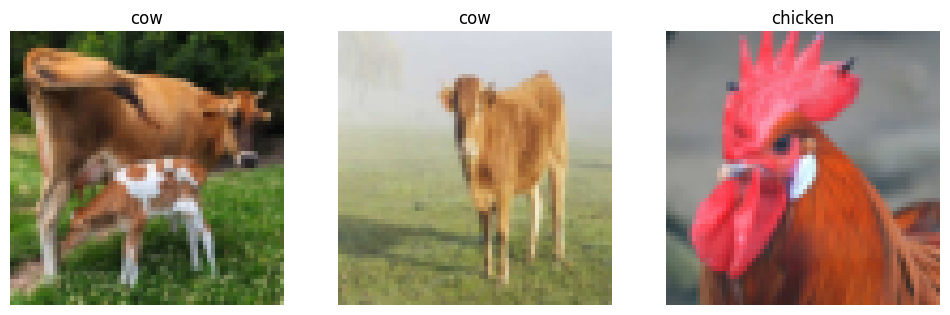

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
for i in range(3):
  img = x_batch[i]
  lbl = train_ds_no_augment.classes[y_batch[i]]

  img = torch.movedim(input=img, source=0, destination=-1)

  axes[i].imshow(img)
  axes[i].axis(False)
  axes[i].set_title(lbl)

# Build a classification model based on the TinyVGG architecture

In [20]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
device

'cuda'

In [21]:
class MyTinyVGG(nn.Module):
  def __init__(self):
    super().__init__()

    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(3,3), stride=1,padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2), stride=2)
    )

    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), stride=1,padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2), stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=10*13*13, out_features=3)
    )

  def forward(self, x):
    x = self.block1(x)
    ## print interim shapes to determine in_features parameter for the classification layer
    # print(f"Shape after block1: {x.shape}")
    x = self.block2(x)
    # print(f"Shape after block2: {x.shape}")
    return self.classifier(x)

In [121]:
model0 = torch.compile(MyTinyVGG().to(device=device))

# Load model0's weights if available

In [ ]:
# @title Load model weights? {"run":"auto","display-mode":"form"}
load_weights = "no" # @param ["no","yes"]

In [ ]:
if load_weights == "yes":
  model0.load_state_dict(torch.load(non_aug_model_weights_dir, weights_only=True))

# Back to creating model

Check input shapes at each stage of the forward pass

Starting shape is `(None, 3, 64, 64)`

In [23]:
single_img_batch = next(iter(train_dl_no_augment))[0].to(device=device)
single_img_batch.shape

torch.Size([16, 3, 64, 64])

In [24]:
model0(single_img_batch)

tensor([[ 0.0114, -0.0021,  0.0190],
        [ 0.0070, -0.0015,  0.0181],
        [ 0.0091, -0.0049,  0.0199],
        [ 0.0131, -0.0041,  0.0184],
        [ 0.0103, -0.0022,  0.0175],
        [ 0.0134, -0.0047,  0.0173],
        [ 0.0107, -0.0037,  0.0180],
        [ 0.0111, -0.0020,  0.0184],
        [ 0.0097, -0.0040,  0.0185],
        [ 0.0116, -0.0027,  0.0191],
        [ 0.0109, -0.0048,  0.0193],
        [ 0.0112, -0.0037,  0.0144],
        [ 0.0119, -0.0030,  0.0192],
        [ 0.0092, -0.0029,  0.0202],
        [ 0.0074, -0.0021,  0.0127],
        [ 0.0121, -0.0049,  0.0153]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)

It returned (16, 10, 13, 13) - now we know what to the shape after flattening is

:)

## Define the loss function and optimizer for the model

In [122]:
LEARNING_RATE = .001

In [123]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(), lr=LEARNING_RATE)

In [ ]:
accuracy_fn = torchmetrics.functional.classification.multiclass_accuracy(preds=logits, target=y_batch, num_classes=3, average='micro')

# Create the train and test functions

In [124]:
def train_step(model:nn.Module, train_dl:torch.utils.data.DataLoader, loss_fn:nn.modules.loss, optimizer:torch.optim)-> tuple:

  total_epoch_loss = 0
  total_epoch_acc = 0
  num_batches = len(train_dl)

  model.train()
  for x_batch, y_batch in train_dl:
    x_batch, y_batch = x_batch.to(device=device), y_batch.to(device=device)

    logits = model(x_batch)
    loss = loss_fn(logits, y_batch)
    total_epoch_loss += loss.item() # avoid accumulating gradients - all we need is the loss value

    accuracy = torchmetrics.functional.classification.multiclass_accuracy(preds=logits, target=y_batch, num_classes=3, average='micro')
    total_epoch_acc += accuracy.item()  # avoid accumulating gradients - all we need is the loss value

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  mean_epoch_loss = total_epoch_loss / num_batches
  mean_epoch_acc = total_epoch_acc / num_batches

  return mean_epoch_loss, mean_epoch_acc


def test_step(model:nn.Module, test_dl:torch.utils.data.DataLoader, loss_fn:nn.modules.loss)-> tuple:

  total_epoch_loss = 0
  total_epoch_acc = 0
  num_batches = len(test_dl)

  model.eval()
  with torch.inference_mode():
    for x_batch, y_batch in test_dl:
      x_batch, y_batch = x_batch.to(device=device), y_batch.to(device=device)

      logits = model(x_batch)
      loss = loss_fn(logits, y_batch)
      total_epoch_loss += loss.item() # avoid accumulating gradients - all we need is the loss value

      accuracy = torchmetrics.functional.classification.multiclass_accuracy(preds=logits, target=y_batch, num_classes=3, average='micro')
      total_epoch_acc += accuracy.item()  # avoid accumulating gradients - all we need is the loss value

  mean_epoch_loss = total_epoch_loss / num_batches
  mean_epoch_acc = total_epoch_acc / num_batches

  return mean_epoch_loss, mean_epoch_acc

# Define the training loop

In [125]:
EPOCHS = 20

In [126]:
train_metrics = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": [],
}

for epoch in range(EPOCHS):
  print(f"Epoch {epoch}/{EPOCHS-1}")

  train_loss, train_acc = train_step(model=model0, train_dl=train_dl_no_augment, loss_fn=loss_fn, optimizer=optimizer)
  test_loss, test_acc = test_step(model=model0, test_dl=test_dl_no_augment, loss_fn=loss_fn)

  train_metrics['train_loss'].append(train_loss)
  train_metrics['train_acc'].append(train_acc)
  train_metrics['test_loss'].append(test_loss)
  train_metrics['test_acc'].append(test_acc)

  print(f"Train loss: {train_loss:.3f} | Train Accuracy: {train_acc:.2f}")
  print(f"Test loss: {test_loss:.3f} | Test Accuracy: {test_acc:.2f}")

Epoch 0/19
Train loss: 1.102 | Train Accuracy: 0.32
Test loss: 1.097 | Test Accuracy: 0.40
Epoch 1/19
Train loss: 1.102 | Train Accuracy: 0.34
Test loss: 1.105 | Test Accuracy: 0.31
Epoch 2/19
Train loss: 1.098 | Train Accuracy: 0.35
Test loss: 1.097 | Test Accuracy: 0.31
Epoch 3/19
Train loss: 1.095 | Train Accuracy: 0.37
Test loss: 1.090 | Test Accuracy: 0.38
Epoch 4/19
Train loss: 1.098 | Train Accuracy: 0.36
Test loss: 1.083 | Test Accuracy: 0.51
Epoch 5/19
Train loss: 1.087 | Train Accuracy: 0.46
Test loss: 1.066 | Test Accuracy: 0.38
Epoch 6/19
Train loss: 1.085 | Train Accuracy: 0.40
Test loss: 1.070 | Test Accuracy: 0.50
Epoch 7/19
Train loss: 1.044 | Train Accuracy: 0.46
Test loss: 0.978 | Test Accuracy: 0.56
Epoch 8/19
Train loss: 1.001 | Train Accuracy: 0.53
Test loss: 1.032 | Test Accuracy: 0.43
Epoch 9/19
Train loss: 1.052 | Train Accuracy: 0.44
Test loss: 1.182 | Test Accuracy: 0.32
Epoch 10/19
Train loss: 1.099 | Train Accuracy: 0.38
Test loss: 1.010 | Test Accuracy: 0.6

# Save the model's weights

In [30]:
non_aug_model_weights_dir = Path("/content/drive/MyDrive", "non_aug_model.pth")
non_aug_model_weights_dir

PosixPath('/content/drive/MyDrive/non_aug_model.pth')

In [31]:
torch.save(model0.state_dict(), non_aug_model_weights_dir)

In [127]:
train_metrics_model0 = train_metrics.copy()

# Plot model0's training history

In [128]:
print(train_metrics_model0["train_loss"])

[1.102259343320673, 1.1017805337905884, 1.0976279323751277, 1.095263416116888, 1.0976905497637661, 1.087182099168951, 1.0849457762458108, 1.0435515371235935, 1.0010342056101018, 1.051940067247911, 1.099066517569802, 1.0223451906984502, 0.9789112156087701, 0.9403748078779741, 0.9184501116926019, 0.909039399840615, 0.950764699415727, 0.8809992833571001, 0.8596975261514838, 0.9310583147135648]


In [129]:
def plot_history(hist_dict:dict)-> None:

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  ax[0].plot(hist_dict["train_loss"], color="blue", label="train loss")
  ax[0].plot(hist_dict["test_loss"], color="green", label="test loss")
  ax[0].legend()

  ax[1].plot(hist_dict["train_acc"], color="blue", label="train accuracy")
  ax[1].plot(hist_dict["test_acc"], color="green", label="test accuracy")
  ax[1].legend()

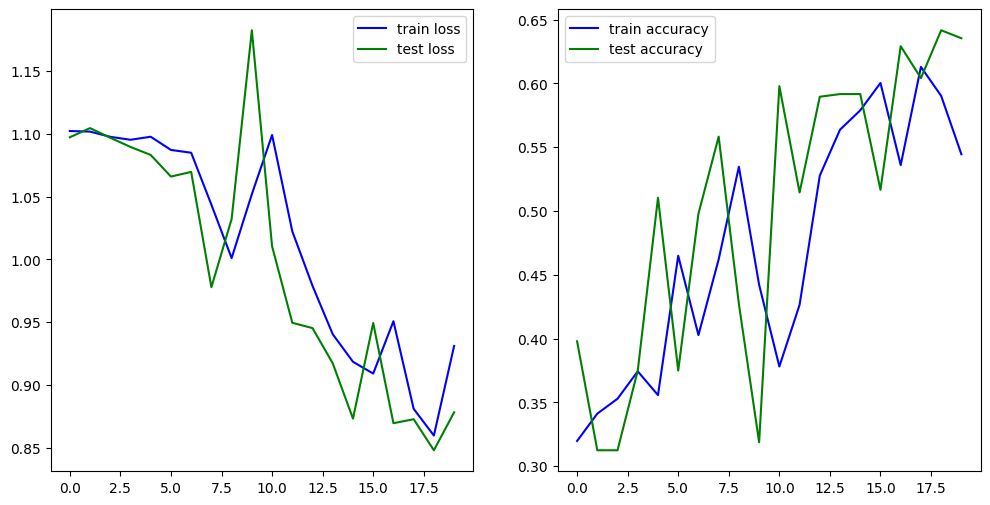

In [130]:
plot_history(train_metrics_model0)

# Evaluate model0

In [36]:
def get_predictions(model:nn.Module, test_dl:torch.utils.data.DataLoader)-> torch.Tensor:

  model.eval()
  with torch.inference_mode():
    batched_predictions = []
    for x_batch, y_batch in test_dl:
        x_batch, y_batch = x_batch.to(device=device), y_batch.to(device=device)
        batch_logits = model(x_batch)
        batch_preds = torch.argmax(batch_logits, dim=1)
        batched_predictions.append(batch_preds)
  predictions = torch.cat(batched_predictions, dim=0).to(device="cpu")

  return predictions

In [131]:
model0_preds = get_predictions(model=model0, test_dl=test_dl_no_augment)
model0_preds

tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 2, 0, 2, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2,
        2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 1,
        0, 2, 2, 2, 2, 0])

In [38]:
model0_preds.shape

torch.Size([150])

In [132]:
y_true = np.array(test_ds_no_augment.targets)
y_true.shape

(150,)

In [133]:
print(classification_report(y_true=y_true, y_pred=model0_preds, target_names=test_ds_no_augment.classes))

              precision    recall  f1-score   support

         cat       0.52      0.72      0.61        50
     chicken       0.64      0.50      0.56        50
         cow       0.81      0.68      0.74        50

    accuracy                           0.63       150
   macro avg       0.66      0.63      0.64       150
weighted avg       0.66      0.63      0.64       150



# Exploring image augmentation techniques available in the torchvision library

## Crate a new test dataset incorporating data augmentation

In [ ]:
test_imgs_dir = IMAGES_DIR / "test"
train_imgs_dir = IMAGES_DIR / "train"

In [61]:
transform_trivial_aug = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(64,64)),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.TrivialAugmentWide()
])

We increase the Batch Size by a factor of 2 to take advantage of the extra images

In [62]:
BATCH_SIZE = 32

In [66]:
train_ds_trivial_aug = torchvision.datasets.ImageFolder(root=train_imgs_dir, transform=transform_trivial_aug)
train_dl_trivial_aug = torch.utils.data.DataLoader(dataset=train_ds_trivial_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=1,  prefetch_factor=3)

The test dataset can stay the same - we don't want to augment it.

Question is, can the test and train datasets have different batch numbers?

In [64]:
test_dl_no_augment

## Let's visualize some transformed images

In [92]:
x_batch, _ = next(iter(test_dl_no_augment))

In [97]:
random_ids = torch.randint(low=0, high=len(x_batch), size=(3,))
random_ids

tensor([7, 8, 0])

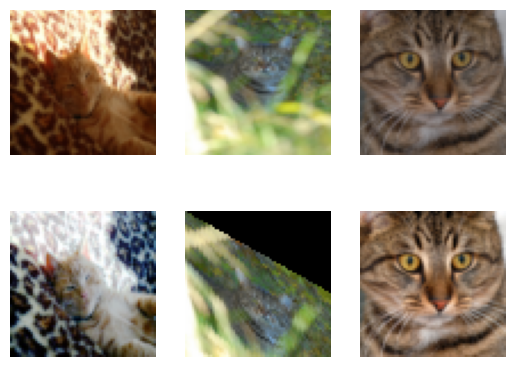

In [98]:
fig, ax = plt.subplots(nrows=2, ncols=3)
for i in range(len(random_ids)):
  img_idx = random_ids[i]
  original_img = x_batch[img_idx]
  transformed_img = transform_trivial_aug(original_img)

  # Move Channel dimension to the end
  original_img = torch.movedim(input=original_img, source=0, destination=-1)
  transformed_img = torch.movedim(input=transformed_img, source=0, destination=-1)

  # Plot original images
  ax[0, i].imshow(original_img)
  ax[0, i].axis(False)

  # Plot transformed images
  ax[1, i].imshow(transformed_img)
  ax[1, i].axis(False)

# Create a new instance of our model

In [134]:
model1 = torch.compile(MyTinyVGG().to(device=device))

## Define the loss function and optimizer for the model

In [135]:
LEARNING_RATE = .002 # Double the learning rate to correspond to the increased batch size

In [136]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model1.parameters(), lr=LEARNING_RATE)

# Define the training loop

In [137]:
EPOCHS = 40 # Double the number of epochs to take advantage of the increased number of samples available thanks to data augmentation

In [138]:
train_metrics = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": [],
}

for epoch in range(EPOCHS):
  print(f"Epoch {epoch}/{EPOCHS-1}")

  train_loss, train_acc = train_step(model=model1, train_dl=train_dl_trivial_aug, loss_fn=loss_fn, optimizer=optimizer)
  test_loss, test_acc = test_step(model=model1, test_dl=test_dl_no_augment, loss_fn=loss_fn)

  train_metrics['train_loss'].append(train_loss)
  train_metrics['train_acc'].append(train_acc)
  train_metrics['test_loss'].append(test_loss)
  train_metrics['test_acc'].append(test_acc)

  print(f"Train loss: {train_loss:.3f} | Train Accuracy: {train_acc:.2f}")
  print(f"Test loss: {test_loss:.3f} | Test Accuracy: {test_acc:.2f}")

Epoch 0/39
Train loss: 1.103 | Train Accuracy: 0.33
Test loss: 1.099 | Test Accuracy: 0.31
Epoch 1/39
Train loss: 1.102 | Train Accuracy: 0.32
Test loss: 1.085 | Test Accuracy: 0.38
Epoch 2/39
Train loss: 1.093 | Train Accuracy: 0.39
Test loss: 1.086 | Test Accuracy: 0.42
Epoch 3/39
Train loss: 1.081 | Train Accuracy: 0.50
Test loss: 1.068 | Test Accuracy: 0.41
Epoch 4/39
Train loss: 1.085 | Train Accuracy: 0.42
Test loss: 1.079 | Test Accuracy: 0.41
Epoch 5/39
Train loss: 1.064 | Train Accuracy: 0.43
Test loss: 1.038 | Test Accuracy: 0.46
Epoch 6/39
Train loss: 1.026 | Train Accuracy: 0.50
Test loss: 1.021 | Test Accuracy: 0.45
Epoch 7/39
Train loss: 1.020 | Train Accuracy: 0.48
Test loss: 1.027 | Test Accuracy: 0.42
Epoch 8/39
Train loss: 1.031 | Train Accuracy: 0.44
Test loss: 1.039 | Test Accuracy: 0.47
Epoch 9/39
Train loss: 0.996 | Train Accuracy: 0.53
Test loss: 1.007 | Test Accuracy: 0.47
Epoch 10/39
Train loss: 0.984 | Train Accuracy: 0.49
Test loss: 0.971 | Test Accuracy: 0.5

# Plot model1's training history

In [139]:
train_metrics_model1 = train_metrics.copy()
print(train_metrics_model1["train_loss"])

[1.1029480045492, 1.1021368286826394, 1.0934137539430098, 1.0809376564892856, 1.0854639140042392, 1.063947395844893, 1.025935167616064, 1.0202194289727644, 1.0305948745120654, 0.9956359917467291, 0.9837440794164484, 0.9925660599361766, 0.9546556147662076, 0.930306461724368, 0.913416629487818, 0.8802963332696394, 0.9048422358252786, 0.882720638405193, 0.8812938386743719, 0.9285914193500172, 0.8803893977945502, 0.9036893302744086, 0.8374800844625994, 0.847703982483257, 0.796819112517617, 0.7661773833361539, 0.8240624395283785, 0.8018620014190674, 0.7242653098973361, 0.82100971178575, 0.7180742675607855, 0.7797308455814015, 0.6984273845499213, 0.6868840157985687, 0.6864090914076025, 0.7746053879911249, 0.7164301330393011, 0.6488828984173861, 0.6412753625349565, 0.6570122539997101]


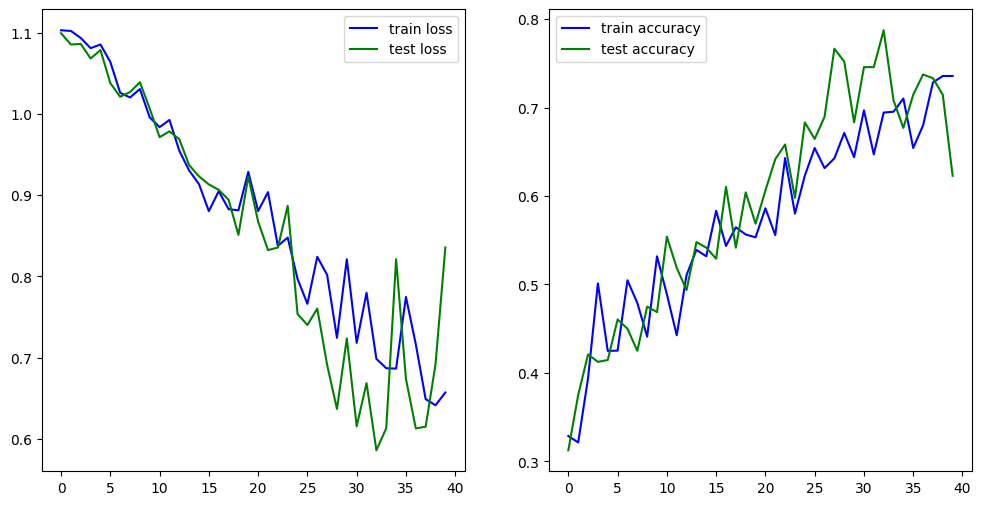

In [140]:
plot_history(train_metrics_model1)

# Evaluate model1

In [141]:
model1_preds = get_predictions(model=model1, test_dl=test_dl_no_augment)
model1_preds

tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0,
        0, 2, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2,
        0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0,
        0, 2, 2, 2, 2, 0])

In [107]:
model1_preds.shape

torch.Size([150])

In [142]:
y_true = np.array(test_ds_no_augment.targets)
y_true.shape

(150,)

In [143]:
print(classification_report(y_true=y_true, y_pred=model1_preds, target_names=test_ds_no_augment.classes))

              precision    recall  f1-score   support

         cat       0.48      0.84      0.61        50
     chicken       0.75      0.30      0.43        50
         cow       0.86      0.72      0.78        50

    accuracy                           0.62       150
   macro avg       0.69      0.62      0.61       150
weighted avg       0.69      0.62      0.61       150



Sooo... it's worse :D :D

# Conclusions
1. I think rotations applied by `TrivialAugmentWide` are too strong if the model will receive real life images
2. Looking at `model0's` learning curves increasing the learning rate for `model1` was a mistake
3. Creating custom datasets from our own images is super easy. Thanks PyTorch 💗
4. I think that the accuracy function from torchmetrics needs to be averaging as 'micro' inside training steps because the given batch might be imbalanced (even if the entire dataset is perfectly balanced) throwing off the results